In [1]:
import glob
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from requests import get
from bs4 import BeautifulSoup

In [2]:
full_df = pd.concat([pd.read_csv(f, compression='gzip') for f in glob.glob("../data/full-data/*.gzip")], ignore_index=True)
full_df

,GLOBALEVENTID,MentionSourceName,MentionIdentifier,MentionDocTone,V2Tone
0,714815243,npr.org,https://www.npr.org/podcasts/510318/up-first,-1.686341,"-1.51745068285281,1.97268588770865,3.490136570..."
1,714914196,npr.org,https://www.npr.org/podcasts/510318/up-first,-1.686341,"-1.51745068285281,1.97268588770865,3.490136570..."
2,714914805,npr.org,https://www.npr.org/podcasts/510318/up-first,-1.686341,"-1.51745068285281,1.97268588770865,3.490136570..."
3,714866405,npr.org,https://www.npr.org/podcasts/510318/up-first,-1.686341,"-1.51745068285281,1.97268588770865,3.490136570..."
4,714712365,npr.org,https://www.npr.org/podcasts/510318/up-first,-1.686341,"-1.51745068285281,1.97268588770865,3.490136570..."
5,714712596,npr.org,https://www.npr.org/podcasts/510318/up-first,-1.686341,"-1.51745068285281,1.97268588770865,3.490136570..."
6,803629825,npr.org,https://www.npr.org/people/2101212/lakshmi-singh,-0.403226,"-0.393700787401575,2.36220472440945,2.75590551..."
7,771526112,npr.org,https://www.npr.org/podcasts/381444767/u-w-m-t...,-1.063830,"-1.00090991810737,1.45586897179254,2.456778889..."
8,754291427,npr.org,https://www.npr.org/podcasts/605235114/idaho-m...,-0.829187,"-0.757575757575757,2.27272727272727,3.03030303..."
9,747811799,npr.org,https://www.npr.org/2018/04/14/602443800/view-...,-0.891720,"-0.880503144654088,2.26415094339623,3.14465408..."


In [3]:
# distribution of nb of articles by sources
nb_articles = full_df.groupby("MentionSourceName").size()
nb_articles.describe()

count        50.000000
mean     118635.340000
std      125467.862077
min        1523.000000
25%       19970.000000
50%       70715.500000
75%      171365.750000
max      430445.000000
dtype: float64

In [4]:
nb_articles.sort_values(ascending=False)

MentionSourceName
nbcnews.com            430445
seattletimes.com       414353
miamiherald.com        386141
foxnews.com            378719
stltoday.com           373903
seattlepi.com          320122
nytimes.com            294935
nydailynews.com        292735
chicagotribune.com     237812
latimes.com            201922
wtop.com               196832
bostonherald.com       189531
newsweek.com           172558
newsmax.com            167789
philly.com             153543
breitbart.com          150822
politico.com           149206
usatoday.com           147423
huffingtonpost.com     117924
cbsnews.com            116948
nypost.com             113003
abc13.com               91387
npr.org                 89467
abc7news.com            83049
newsday.com             82108
boston.com              59323
mercurynews.com         55149
ktla.com                49480
denverpost.com          46420
fox2now.com             41890
kron4.com               32644
wgntv.com               30557
kdvr.com              

In [5]:
sources = nb_articles.sort_values(ascending=False).index.values

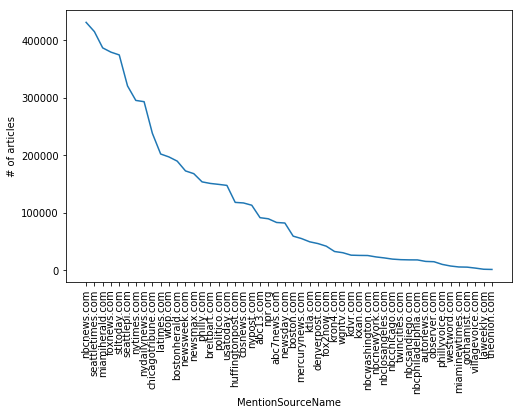

In [6]:
plt.figure(figsize=(8,5))
nb_articles.sort_values(ascending=False).plot()
plt.xticks(range(len(sources)), sources, rotation=90)
plt.ylabel("# of articles")
plt.show()

In [7]:
with open("../data/map_sources_url_to_name.pkl", "rb") as f:
    name_map = pickle.load(f)

In [8]:
def get_icon(website, errors):
    possible = ["shortcut icon", "icon", "Shortcut Icon"]
    my_header = {'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:63.0) Gecko/20100101 Firefox/63.0",}
    url = "http://"+website
    try:
        r = get(url, headers=my_header)
        soup = BeautifulSoup(r.text, 'html.parser')
        icon_link = None
        i = 0
        while icon_link is None:
            icon_link = soup.find("link", rel=possible[i])
            i+=1
        try:
            icon = get(icon_link['href'], headers=my_header)
            url = icon_link['href']
        except:
            icon = get(url + icon_link['href'], headers=my_header)
            url += icon_link['href']
        return url
    except:
        errors.append(website)

In [9]:
events_covered = full_df.groupby("MentionSourceName")["GLOBALEVENTID"].unique()

In [10]:
full_df["avg_tone"] = full_df.V2Tone.map(lambda l : str(l).split(",")[0]).astype(float)

In [12]:
avg_tone_by_source_x_event = full_df.groupby(["MentionSourceName","GLOBALEVENTID"]).mean()["avg_tone"]

In [26]:
nodes = []
edges = []
errors_icon = []
new_sources = set(sources)

for source1 in tqdm_notebook(sources):
    nodes.append({  'id' : source1, 
                    'size' : int(nb_articles[source1]), 
                    'name' : name_map[source1],
                    'favicon' : get_icon(source1, errors_icon),
                    'avg_tone' : avg_tone_by_event_x_source[:,source1].mean(),
                 })
    
    events1 = set(events_covered[source1])
    new_sources = new_sources - {source1}
    
    for source2 in new_sources:
        if source1==source2:
            continue
            
        events2 = set(events_covered[source2])
        coverage_ratio = len(events1 & events2) / len(events1 | events2)
        
        tone_diff = np.abs(avg_tone_by_source_x_event[source1]-avg_tone_by_source_x_event[source2]).dropna().mean()
        
        edges.append({'source': source1, 'target': source2, 'weight': coverage_ratio, 'tone_diff': tone_diff})  

In [47]:
errors_icon

['seattletimes.com',
 'seattlepi.com',
 'chicagotribune.com',
 'bostonherald.com',
 'npr.org',
 'gothamist.com']

In [48]:
for n in nodes:
    if n["id"] == "npr.org":
        n['favicon'] = "https://media.npr.org/templates/favicon/favicon-32x32.png"
    if n["id"] == 'http://chicagotribune.com':
        n['favicon'] = 'https://s.m.huffpost.com/assets/favicon-2020e123c064086aad150fe909c53771f862d7c76cd62f6146e81d533845fd7d.ico'

In [49]:
nodes

[{'id': 'nbcnews.com',
  'size': 430445,
  'name': 'NBC News',
  'favicon': 'https://nodeassets.nbcnews.com/cdnassets/projects/ramen/favicon/nbcnews/all-other-sizes-PNG.ico/favicon.ico',
  'avg_tone': -2.8491028024207967},
 {'id': 'seattletimes.com',
  'size': 414353,
  'name': 'The Seattle Times',
  'favicon': None,
  'avg_tone': -3.994206788905626},
 {'id': 'miamiherald.com',
  'size': 386141,
  'name': 'Miami Herald ',
  'favicon': 'https://www.miamiherald.com/wps/source/images/miamiherald/favicon.png',
  'avg_tone': -3.0701679714514674},
 {'id': 'foxnews.com',
  'size': 378719,
  'name': 'Fox News ',
  'favicon': 'http://foxnews.com//static.foxnews.com/static/orion/styles/img/fox-news/favicons/favicon.ico',
  'avg_tone': -3.9053042914540517},
 {'id': 'stltoday.com',
  'size': 373903,
  'name': 'STLtoday',
  'favicon': 'https://www.stltoday.com/content/tncms/site/icon.ico',
  'avg_tone': -3.1432409729491435},
 {'id': 'seattlepi.com',
  'size': 320122,
  'name': 'Seattlepi',
  'favic

In [50]:
len(edges)

1225

In [51]:
for i in np.arange(0,0.051,0.005):
    threshold = i
    filtered_edges = [ e for e in edges if e['weight'] > threshold ]
    network = {'nodes': nodes, 'edges': filtered_edges}
    with open("../data/top"+str(len(nodes))+"-US-year/threshold_"+str(int(threshold*1000))+"_permille.json", "w") as f:
        json.dump(network, f, indent=2)

In [29]:
with open("../data/top"+str(len(nodes))+"-US-year/threshold_0_permille.json", "r") as f:
    test = json.load(f)